# VGG Model

- https://arxiv.org/abs/1409.1556
- https://arxiv.org/pdf/1409.1556

1. 직접 VGG Model 을 만든다
2. 남이 만든 VGG Model 을 사용

## 1. VGG Model 만들기

In [32]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

### 전처리

In [ ]:
transform = Compose([
    RandomCrop((32, 32), padding=4),        # padding : 과적합 방지
    RandomHorizontalFlip(p=0.5),            # 50% 확률로 랜덤하게 좌우반전 -> 다양성
    T.ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))     # CIFAR10 정규화 값이 이미 나와있음
    # 흑백은 정규화가 필요 없지만, 컬러는 필요(특정 색 값이 튀면 정답이라고 말할 확률높음)
    # ex. 사과를 보여줬는데, 빨강색이면 무조건 딸기라고 말함
])

train_data = CIFAR10(root="./", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./", train=False, download=True, transform=transform)

In [34]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [35]:
train_data.targets[0]
# 6 -> frog

6

In [36]:
train_data.data[0].shape
# (32, 32, 3) -> (width, height, channel)
# tensor 형태는 (channel, width, height)

(32, 32, 3)

### 데이터셋 만들기

In [37]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [38]:
img_data = iter(train_loader)
images, labels = next(img_data)
images.shape

torch.Size([32, 3, 32, 32])

In [39]:
images[0].shape

torch.Size([3, 32, 32])

In [40]:
img_data = images[0]
img_data = img_data.numpy()
img_data.shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].


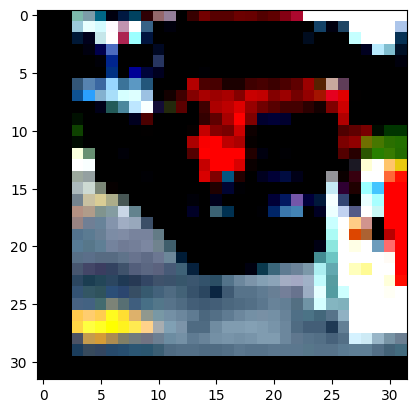

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(img_data, (1, 2, 0)))
plt.show()

# DataLoader 를 통과한 이미지는 채널의 순서가 변경된다 (channel(0), width(1), height(2))
# matplotlib 으로 그릴때는 (width, height, channel)
# DataLoader 를 통해 불러온 이미지는 자료형이 tensor 이므로 numpy로 변경후 사용, 순서도 변경 (1, 2, 0)
# 그래서 위에서 np.transpose(img_data, (1, 2, 0)) 이렇게 해주는 것


In [42]:
# 정규화 풀어주는 함수
def denomalize(img, mean, std) :
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# dataloader를 통해 불러온 tensor 형태의 이미지를 넣었을때 numpy로 바꿔주는 함수
def view_img(image) :
    mean=(0.4914, 0.4822, 0.4465)
    std=(0.247, 0.243, 0.261)

    img_data = denomalize(image, mean, std)
    img_data = img_data.numpy()
    plt.imshow(np.transpose(img_data, (1, 2, 0)))
    plt.show()

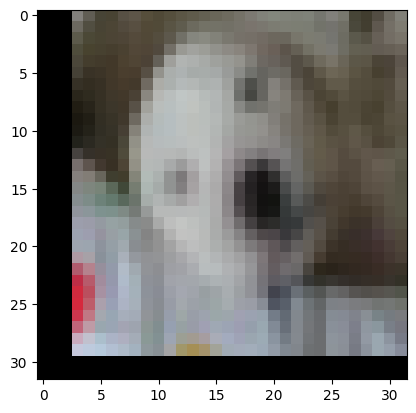

In [20]:
view_img(images[3])

### 모델 생성

- conv 거치면 거칠수록 특징이 많아짐
- 이미지가 크면 클수록 layer를 깊게 쌓아야함 -> 더 디테일한 특징 찾을수있음

In [44]:
class BasicBlock(nn.Module) :
    def __init__(self, in_channels, out_channels, hidden_dim) :
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        return x

In [ ]:
# conv-layer 통과후 이미지 사이즈
# 계산 : (width + 2*padding - filterSize)/(Stride)  + 1
# (32 + 2*1 - 3)/(1)  + 1 = 32  -> 사이즈 그대로
# pooling size : (imgSize - PollingSize)/(Stride of the convolution operation) + 1
# (32 - 2) / 2  + 1 = 16

In [45]:
class Vgg16(nn.Module) :
    def __init__(self, num_classes) :
        super(Vgg16, self).__init__()

        self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)     # imgSize : 16*16
        self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)   # imgSize : 8*8
        self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128) # imgSize : 4*4

        # 특징 : 256(out) * 4 * 4 = 4096

        # 평평하게 편다
        # 이미지 다른 사이즈 가져올때 in_features 계산해서 바꿔줘야함
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)       # in_features 는 정해진값, out_features는 맘대로
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes) # 마지막에 빠져나오는 개수는 클래스 개수만큼(num_classes)

        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, start_dim=1)       # 1차원으로 펴줌
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [46]:
model = Vgg16(10)
model

Vgg16(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=25

### 모델 학습

```
uv add tqdm
```
- 진행상황 알 수 있음(bar 형태)

In [47]:
from torch.utils.tensorboard import SummaryWriter
import tqdm

writer = SummaryWriter()
lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
epochs = 20
step = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(epochs) :
    for data, label in tqdm.tqdm(train_loader):
        optim.zero_grad()

        preds = model(data.to(device))
        loss = criterion(preds, label.to(device))

        loss.backward()
        optim.step()

        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1

    print(f"{epoch} loss ::: {loss.item()}")

100%|██████████| 1563/1563 [00:39<00:00, 39.46it/s]


0 loss ::: 1.3831344842910767


100%|██████████| 1563/1563 [00:44<00:00, 34.96it/s]


1 loss ::: 0.93770432472229


100%|██████████| 1563/1563 [00:46<00:00, 33.90it/s]


2 loss ::: 0.41923820972442627


100%|██████████| 1563/1563 [00:41<00:00, 37.23it/s]


3 loss ::: 0.6680034399032593


100%|██████████| 1563/1563 [00:41<00:00, 37.43it/s]


4 loss ::: 1.1094331741333008


100%|██████████| 1563/1563 [00:38<00:00, 40.17it/s]


5 loss ::: 0.6183764934539795


100%|██████████| 1563/1563 [01:01<00:00, 25.43it/s]


6 loss ::: 0.6349638104438782


100%|██████████| 1563/1563 [00:55<00:00, 28.31it/s]


7 loss ::: 0.4977484345436096


100%|██████████| 1563/1563 [00:35<00:00, 44.59it/s]


8 loss ::: 0.8979056477546692


100%|██████████| 1563/1563 [00:35<00:00, 44.59it/s]


9 loss ::: 1.061249017715454


100%|██████████| 1563/1563 [00:31<00:00, 49.70it/s]


10 loss ::: 0.4371585547924042


100%|██████████| 1563/1563 [00:33<00:00, 46.09it/s]


11 loss ::: 0.5395097732543945


100%|██████████| 1563/1563 [00:36<00:00, 43.14it/s]


12 loss ::: 0.41617551445961


100%|██████████| 1563/1563 [00:35<00:00, 44.56it/s]


13 loss ::: 0.5322353839874268


100%|██████████| 1563/1563 [00:36<00:00, 43.34it/s]


14 loss ::: 0.7085621356964111


100%|██████████| 1563/1563 [00:44<00:00, 35.05it/s]


15 loss ::: 0.5777297019958496


100%|██████████| 1563/1563 [00:43<00:00, 35.99it/s]


16 loss ::: 0.31437620520591736


100%|██████████| 1563/1563 [00:40<00:00, 38.96it/s]


17 loss ::: 0.6702589988708496


100%|██████████| 1563/1563 [00:41<00:00, 38.08it/s]


18 loss ::: 0.5382178425788879


100%|██████████| 1563/1563 [00:45<00:00, 34.59it/s]

19 loss ::: 1.0118370056152344


In [ ]:
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32768x4 and 4096x2048)
# x = torch.flatten(x, start_dim=1) -> 평평하게 펴줘야함

In [ ]:
# uv run tensorboard --logdir=runs

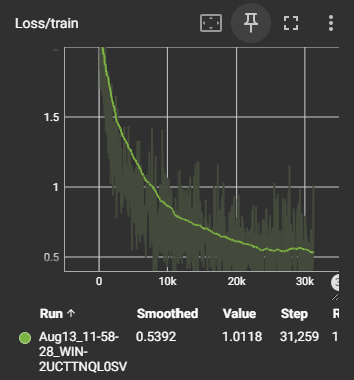

---

## 2. 실제 모델

- 나의 데이터셋이 많으면 가중치를 가져오지 않고, 내 데이터로만 학습시키는게 좋다
- 나의 데이터셋이 적으면 학습된 가중치를 가져와서 재학습 시키는게 좋다

In [ ]:
from torchvision.models.vgg import vgg16

model = vgg16(pretrained=True)          # pretrained : 학습된 가중치 들고오기
model

c:\deep_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\deep_learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
0.7%

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Dropout : 50%의 확률로 가지치기 -> 과적합 줄어들 수도 있다
# 우리가 모델을 가져와서 사용할때는 제일 밑에 나오는 분류기(classifier) 의 값들을 변경시켜서 사용한다 - in_features, out_feaures 값을 알맞게 변경

### 분류기(classifier) 교체

In [49]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [50]:
# Linear(in_features=4096, out_features=1000, bias=True) -> out_features=1000개지만, 우린 10으로 바꾸고 싶다
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 10)     
)

# 분류기 교체(classifier)
model.classifier = fc
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 모델 학습

In [ ]:
# in_features 가 다르기 때문에 에러날 것이다

In [ ]:
model.avgpool
# 모델 자체에 avgpool 이 있기 때문에 항상 output_size=(7, 7) 이렇게 맞춰줌
# 오히려 성능을 낮출 수 있다 -> 빼고 쓰는걸 추천!

AdaptiveAvgPool2d(output_size=(7, 7))